In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

In [2]:
# Create engine using the `hawaii.sqlite` database file created in database_engineering steps
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Reflect Database into ORM class
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# Start a session to query the database
session = Session(engine)

In [7]:
# Retrieve the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
# to get the last 12 months of data, last date - 365
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

('2017-08-23',)
2016-08-23


In [8]:
# query to pull the last year of precipitation data
rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).order_by(Measurement.date).all()

In [9]:
# from query to dataframe
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


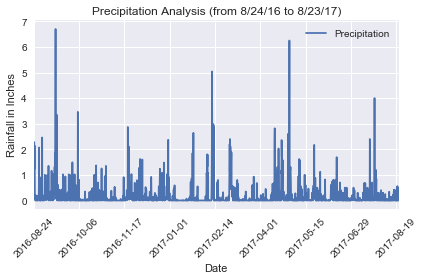

In [10]:
# plot the dataframe
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rainfall in Inches")
plt.title("Precipitation Analysis (from 8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Count the number of stations in the Measurement table
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [13]:
# find the station with the most observations
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest station was", busiest,"with a total of", busy_station[0][1], "observations")
print()

# list stations in descending order of observation counts
print("Stations and observation counts in descending order:")
for station, count in busy_station:
    print("Station", station, "had", count, "observations")

The busiest station was USC00519281 with a total of 2772 observations

Stations and observation counts in descending order:
Station USC00519281 had 2772 observations
Station USC00513117 had 2696 observations
Station USC00519397 had 2685 observations
Station USC00519523 had 2572 observations
Station USC00516128 had 2484 observations
Station USC00514830 had 1937 observations
Station USC00511918 had 1932 observations
Station USC00517948 had 683 observations
Station USC00518838 had 342 observations


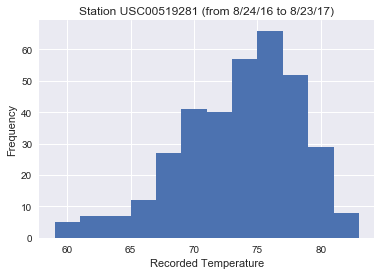

In [14]:
# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                            filter(Measurement.station == busiest).\
                            filter(Measurement.date > last_year).\
                            order_by(Measurement.date).all()

# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'], 12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station "+busiest+" (from 8/24/16 to 8/23/17)")
plt.show()

In [15]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
temp_range = (calc_temps('2012-02-28', '2012-03-05'))
print(temp_range)

[(62, 69.3921568627451, 74)]


In [16]:
# calculate the min/max/avg from last year that matches my trip date
trip_arrive = dt.date(2018, 5, 1)
trip_leave = dt.date(2018, 5, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))

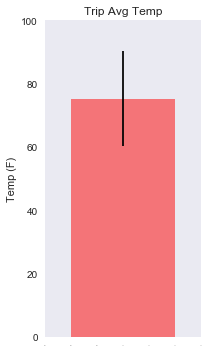

In [17]:
# Plot calculated min/max/avg from last year for the trip dates as a bar chart

peak_to_peak = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avg_temp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]


plt.figure(figsize=[3, 5])
plt.grid(b=None)
plt.bar(1, avg_temp, color= 'red', alpha=0.5, yerr=peak_to_peak)

plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
       
plt.ylim(0, 100)
plt.xlim(0.4, 1.6)
plt.tick_params(axis='x', labelsize=0)
plt.tight_layout()
plt.show()